In [1]:
import os
from dotenv import load_dotenv
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [2]:
llm=ChatGroq(model="qwen-2.5-32b")
# llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003681371, 'queue_time': 0.449433511, 'total_time': 0.053681371}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-e722f580-4610-44ad-b8b6-5c2d052edcbb-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

In [3]:
class AgentState(TypedDict):
    pass

def userInputRequirement():
    pass

# def subGraph1():
#     pass

# def subGraph2():
#     pass

def monitoringAndFeedback():
    pass

def maintenanceAndUpdates():
    pass

def route_maintenance_and_updates():
    pass

# class subGraph_1(TypedDict):
#     pass

def generateUserStories():
    pass

def productOwnerReview():
    pass

def reviseUserStories():
    pass

def createDesignDocuments():
    pass

def designReview():
    pass

def route_product_owner_review():
    pass

def route_design_review():
    pass

# class subGraph_2(TypedDict):
#     pass

def generateCode():
    pass

def codeReview():
    pass

def fixCodeAfterCodeReview():
    pass

def securityReview():
    pass

def fixCodeAfterSecurity():
    pass

def writeTestCases():
    pass

def testCasesReview():
    pass

def fixTestCasesAfterReview():
    pass

def qaTesting():
    pass

def fixCodeAfterQAFeedback():
    pass

def deployment():
    pass

def route_code_review():
    pass

def route_security_review():
    pass

def route_test_cases_review():
    pass

def route_qa_testing():
    pass

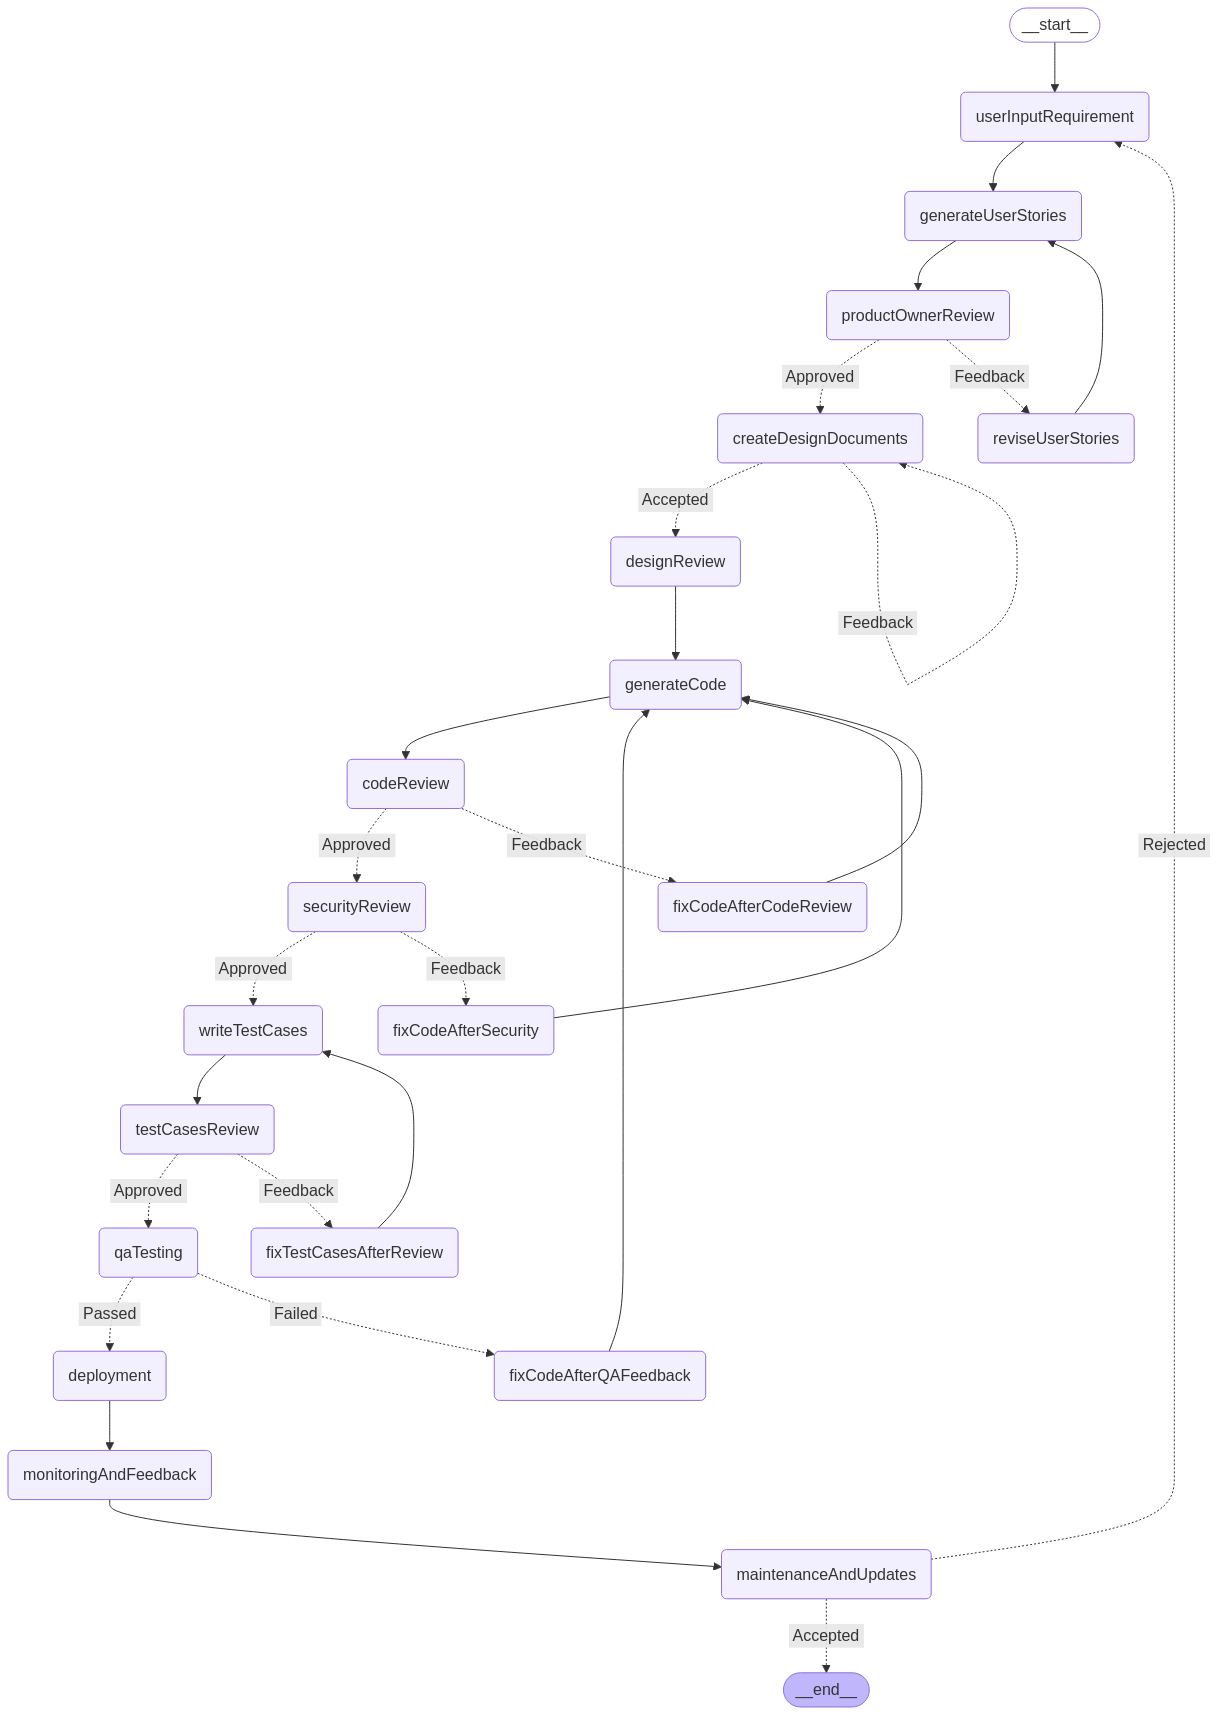

In [4]:
# Build workflow
workflow = StateGraph(AgentState)

# workflow1 = StateGraph(AgentState)
# workflow2 = StateGraph(subGraph_1)
# workflow3 = StateGraph(subGraph_2)

# Add nodes
workflow.add_node("userInputRequirement", userInputRequirement)
workflow.add_node("generateUserStories", generateUserStories)
workflow.add_node("productOwnerReview", productOwnerReview)
workflow.add_node("reviseUserStories", reviseUserStories)
workflow.add_node("createDesignDocuments", createDesignDocuments)
workflow.add_node("designReview", designReview)
workflow.add_node("generateCode", generateCode)
workflow.add_node("codeReview", codeReview)
workflow.add_node("fixCodeAfterCodeReview", fixCodeAfterCodeReview)
workflow.add_node("securityReview", securityReview)
workflow.add_node("fixCodeAfterSecurity", fixCodeAfterSecurity)
workflow.add_node("writeTestCases", writeTestCases)
workflow.add_node("testCasesReview", testCasesReview)
workflow.add_node("fixTestCasesAfterReview", fixTestCasesAfterReview)
workflow.add_node("qaTesting", qaTesting)
workflow.add_node("fixCodeAfterQAFeedback", fixCodeAfterQAFeedback)
workflow.add_node("deployment", deployment)
workflow.add_node("monitoringAndFeedback", monitoringAndFeedback)
workflow.add_node("maintenanceAndUpdates", maintenanceAndUpdates)


# # Workflow 1
# workflow1.add_node("userInputRequirement", userInputRequirement)
# workflow1.add_node("subGraph1", subGraph1)
# workflow1.add_node("subGraph2", subGraph2)
# workflow1.add_node("deployment", deployment)
# workflow1.add_node("monitoringAndFeedback", monitoringAndFeedback)
# workflow1.add_node("maintenanceAndUpdates", maintenanceAndUpdates)

# # Workflow 2
# workflow2.add_node("generateUserStories", generateUserStories)
# workflow2.add_node("productOwnerReview", productOwnerReview)
# workflow2.add_node("reviseUserStories", reviseUserStories)
# workflow2.add_node("createDesignDocuments", createDesignDocuments)
# workflow2.add_node("designReview", designReview)

# # Workflow 3
# workflow3.add_node("generateCode", generateCode)
# workflow3.add_node("codeReview", codeReview)
# workflow3.add_node("fixCodeAfterCodeReview", fixCodeAfterCodeReview)
# workflow3.add_node("securityReview", securityReview)
# workflow3.add_node("fixCodeAfterSecurity", fixCodeAfterSecurity)
# workflow3.add_node("writeTestCases", writeTestCases)
# workflow3.add_node("testCasesReview", testCasesReview)
# workflow3.add_node("fixTestCasesAfterReview", fixTestCasesAfterReview)
# workflow3.add_node("qaTesting", qaTesting)
# workflow3.add_node("fixCodeAfterQAFeedback", fixCodeAfterQAFeedback)

# Add edges to connect nodes
workflow.add_edge(START, "userInputRequirement")
workflow.add_edge("userInputRequirement", "generateUserStories")
workflow.add_edge("generateUserStories", "productOwnerReview")
workflow.add_conditional_edges(
    "productOwnerReview",
    route_product_owner_review,
    {
        "Approved": "createDesignDocuments",
        "Feedback": "reviseUserStories",
    },
)
workflow.add_edge("reviseUserStories", "generateUserStories")
workflow.add_conditional_edges(
    "createDesignDocuments",
    route_design_review,
    {
        "Accepted": "designReview",
        "Feedback": "createDesignDocuments",
    },
)
workflow.add_edge("designReview", "generateCode")
workflow.add_edge("generateCode", "codeReview")
workflow.add_conditional_edges(
    "codeReview",
    route_code_review,
    {
        "Approved": "securityReview",
        "Feedback": "fixCodeAfterCodeReview",
    },
)
workflow.add_edge("fixCodeAfterCodeReview", "generateCode")
workflow.add_conditional_edges(
    "securityReview",
    route_security_review,
    {
        "Approved": "writeTestCases",
        "Feedback": "fixCodeAfterSecurity",
    },
)
workflow.add_edge("fixCodeAfterSecurity", "generateCode")
workflow.add_edge("writeTestCases", "testCasesReview")
workflow.add_conditional_edges(
    "testCasesReview",
    route_test_cases_review,
    {
        "Approved": "qaTesting",
        "Feedback": "fixTestCasesAfterReview",
    },
)
workflow.add_edge("fixTestCasesAfterReview", "writeTestCases")
workflow.add_conditional_edges(
    "qaTesting",
    route_qa_testing,
    {
        "Passed": "deployment",
        "Failed": "fixCodeAfterQAFeedback",
    },
)
workflow.add_edge("fixCodeAfterQAFeedback", "generateCode")
workflow.add_edge("deployment", "monitoringAndFeedback")
workflow.add_edge("monitoringAndFeedback", "maintenanceAndUpdates")
workflow.add_conditional_edges(
    "maintenanceAndUpdates",
    route_maintenance_and_updates,
    {
        "Accepted": END,
        "Rejected": "userInputRequirement",
    },
)


# # Workflow 1
# workflow1.add_edge(START, "userInputRequirement")
# workflow1.add_edge("userInputRequirement", "subGraph1")
# workflow1.add_edge("subGraph1", "subGraph2")
# workflow1.add_edge("subGraph2", "deployment")
# workflow1.add_edge("deployment", "monitoringAndFeedback")
# workflow1.add_edge("monitoringAndFeedback", "maintenanceAndUpdates")
# workflow1.add_conditional_edges(
#     "maintenanceAndUpdates",
#     route_maintenance_and_updates,
#     {
#         "Accepted": END,
#         "Rejected": "userInputRequirement",
#     },
# )

# # Workflow 2
# workflow2.add_edge(START, "generateUserStories")
# workflow2.add_edge("generateUserStories", "productOwnerReview")
# workflow2.add_conditional_edges(
#     "productOwnerReview",
#     route_product_owner_review,
#     {
#         "Approved": "createDesignDocuments",
#         "Feedback": "reviseUserStories",
#     },
# )
# workflow2.add_edge("reviseUserStories", "generateUserStories")
# workflow2.add_conditional_edges(
#     "createDesignDocuments",
#     route_design_review,
#     {
#         "Accepted": "designReview",
#         "Feedback": "createDesignDocuments",
#     },
# )
# workflow2.add_edge("designReview", END)

# # Workflow 3
# workflow3.add_edge(START, "generateCode")
# workflow3.add_edge("generateCode", "codeReview")
# workflow3.add_conditional_edges(
#     "codeReview",
#     route_code_review,
#     {
#         "Approved": "securityReview",
#         "Feedback": "fixCodeAfterCodeReview",
#     },
# )
# workflow3.add_edge("fixCodeAfterCodeReview", "generateCode")
# workflow3.add_conditional_edges(
#     "securityReview",
#     route_security_review,
#     {
#         "Approved": "writeTestCases",
#         "Feedback": "fixCodeAfterSecurity",
#     },
# )
# workflow3.add_edge("fixCodeAfterSecurity", "generateCode")
# workflow3.add_edge("writeTestCases", "testCasesReview")
# workflow3.add_conditional_edges(
#     "testCasesReview",
#     route_test_cases_review,
#     {
#         "Approved": "qaTesting",
#         "Feedback": "fixTestCasesAfterReview",
#     },
# )
# workflow3.add_edge("fixTestCasesAfterReview", "writeTestCases")
# workflow3.add_conditional_edges(
#     "qaTesting",
#     route_qa_testing,
#     {
#         "Passed": END,
#         "Failed": "fixCodeAfterQAFeedback",
#     },
# )
# workflow3.add_edge("fixCodeAfterQAFeedback", "generateCode")

# Compile
chain = workflow.compile()
# chain1 = workflow1.compile()
# chain2 = workflow2.compile()
# chain3 = workflow3.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))
# display(Image(chain1.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))
# display(Image(chain2.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))
# display(Image(chain3.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))